## Data Analysis

### 1. Importing different libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

In [2]:
try:
    with open("../config.yaml", "r") as file:
        config = yaml.safe_load(file)
except:
    print("Configuration file not found!")

In [3]:
config

{'input_data': {'file': '../data/raw/sleep_health_and_lifestyle_dataset.csv'},
 'output_data': {'file': '../data/clean/sleep_health_project_clean.csv'}}

In [4]:
sleep_df_clean = pd.read_csv(config['output_data']['file'], encoding='ISO-8859-1')
sleep_df_clean.head(5)

,person_id,gender,age,occupation,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,bmi_category,blood_pressure,heart_rate,daily_steps,sleep_disorder,systolic,diastolic
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,No Disorder,126,83
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,No Disorder,125,80
2,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea,140,90
3,6,Male,28,Software Engineer,5.9,4,30,8,Obese,140/90,85,3000,Insomnia,140,90
4,7,Male,29,Teacher,6.3,6,40,7,Obese,140/90,82,3500,Insomnia,140,90


#### 1.1 Basic casting of dataframe

In [5]:
sleep_df_clean.shape

(132, 15)

In [6]:
sleep_df_clean.dtypes

person_id                    int64
gender                      object
age                          int64
occupation                  object
sleep_duration             float64
quality_of_sleep             int64
physical_activity_level      int64
stress_level                 int64
bmi_category                object
blood_pressure              object
heart_rate                   int64
daily_steps                  int64
sleep_disorder              object
systolic                     int64
diastolic                    int64
dtype: object

### 2.  Exploratory Data Analysis (EDA)

In [7]:
import statsmodels.api as sm

from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

In [8]:
my_palette1 = sns.color_palette("Greens")
my_palette2 = sns.color_palette("Oranges")
my_palette3 = sns.color_palette("Blues")

Work on a copy of the original DataFrame.

In [9]:
sleep_df_clean = sleep_df_clean.copy()

Numeric distribution.

In [10]:
numeric_cols = ['age',
                'sleep_duration',
                'quality_of_sleep',
                'physical_activity_level',
                'stress_level',
                'heart_rate',
                'daily_steps',
                'systolic',
                'diastolic']

In [11]:
categorical_cols = ['gender',
                       'occupation',
                       'bmi_category',
                       'sleep_disorder']

In [12]:
sleep_df_clean.groupby("gender")["age"].mean()

gender
Female    45.830769
Male      36.567164
Name: age, dtype: float64

#### 2.1 Age Distribution by Gender

Text(0.6, 1.0, 'Age Distribution by Gender')

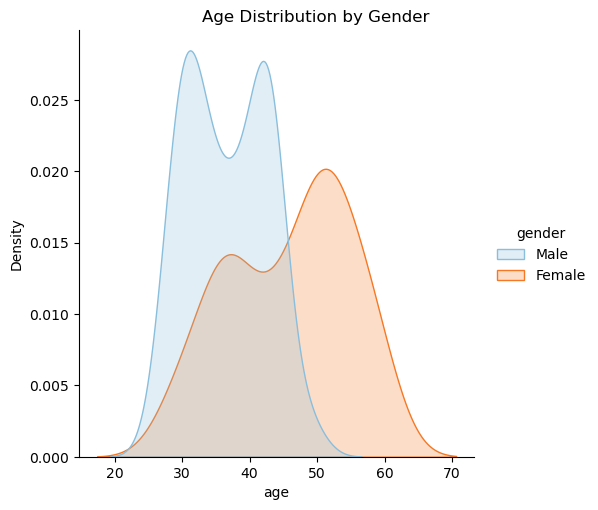

In [13]:
palette = [my_palette3[2], my_palette2[3]]

sns.displot(
    x="age",
    data=sleep_df_clean,
    hue="gender",
    palette=palette,
    kind="kde",
    fill=True)
plt.title("Age Distribution by Gender", x=0.6)

#### 2.2 Age Distribution based on Sleep Disorder

Text(0.6, 1.0, 'Age Distribution based on Sleep Disorder')

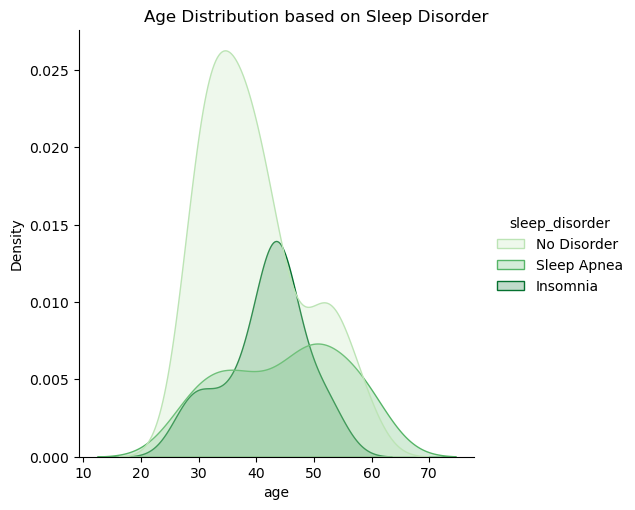

In [14]:
palette = [my_palette1[1], my_palette1[3], my_palette1[5]]

sns.displot(
    x="age",
    data=sleep_df_clean,
    hue="sleep_disorder",
    palette=palette,
    kind="kde",
    fill=True)

plt.title("Age Distribution based on Sleep Disorder",x=0.6)

#### 2.3 Distribution of Sleep Disorders by Gender

Text(0.5, 0, 'sleep_disorder')

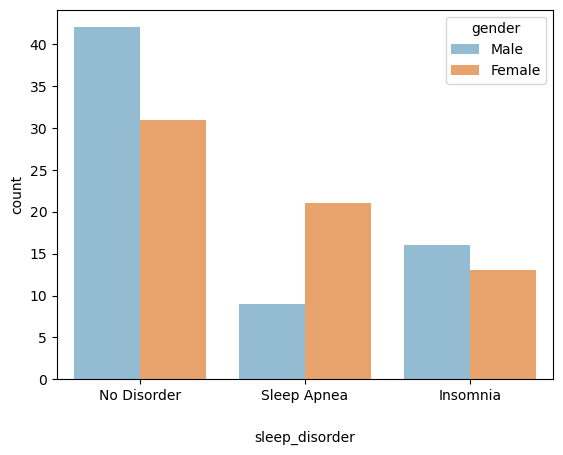

In [15]:
ax = sns.countplot(
    x= sleep_df_clean["sleep_disorder"], 
    data= sleep_df_clean, 
    hue= sleep_df_clean["gender"], 
    palette=[my_palette3[2], my_palette2[2]]
)
ax.set_xlabel("sleep_disorder", labelpad=20)

#### 2.4 Distribution of BMI Categories by Sleep Disorder

Text(0.5, 1.0, 'Distribution of BMI Categories by Sleep Disorder')

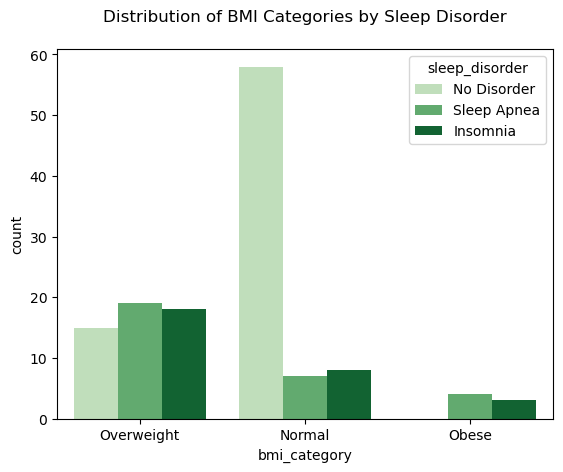

In [16]:
ax = sns.countplot(
    x = sleep_df_clean["bmi_category"],
    hue = sleep_df_clean["sleep_disorder"],
    data = sleep_df_clean,
    palette = [my_palette1[1], my_palette1[3], my_palette1[5]]
)
ax.set_title("Distribution of BMI Categories by Sleep Disorder", pad=20)

#### 2.5 Distribution of Sleep Quality by Sleep Disorder

Text(0.5, 1.0, 'Distribution of Sleep Quality by Sleep Disorder')

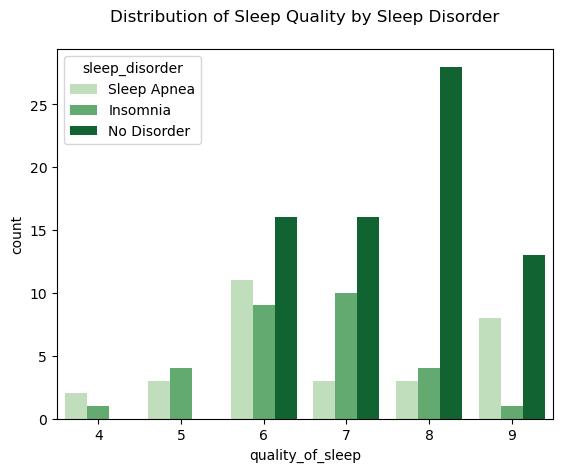

In [17]:
ax = sns.countplot(
    x = sleep_df_clean["quality_of_sleep"],
    hue = sleep_df_clean["sleep_disorder"],
    data = sleep_df_clean,
    palette = [my_palette1[1], my_palette1[3], my_palette1[5]]
)
ax.set_title("Distribution of Sleep Quality by Sleep Disorder", pad=20)

#### 2.6 Distribution of Sleep Duration by Sleep Disorder

/var/folders/lr/d46q9z0s2zndy_5npx2_zwq00000gn/T/ipykernel_3819/3804374456.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


Text(0.5, 1.0, 'Distribution of Sleep Duration by Disorder')

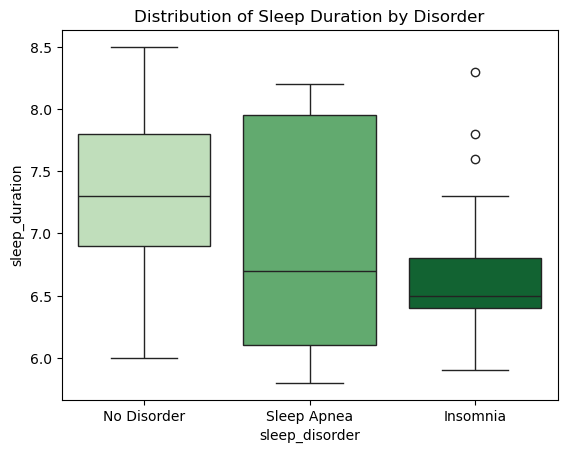

In [18]:
ax = sns.boxplot(
    x = sleep_df_clean["sleep_disorder"],
    y = sleep_df_clean["sleep_duration"],
    palette = [my_palette1[1], my_palette1[3], my_palette1[5]]
)
ax.set_title("Distribution of Sleep Duration by Disorder")

### 4. Univariate Analysis
Analysis of one variable at a time to understand its distribution, central tendency, and spread.

In [19]:
def univariate_analysis(df, numeric_columns, categorical_columns):

    """
    Performs univariate analysis: distributions, statistics, and plots.
    Args:
        df (pd.DataFrame): Dataset.
        numeric_columns (list): List of numeric column names.
        categorical_columns (list): List of categorical column names.
    """
    
    for col in numeric_columns:
        print(f"\n===== {col} =====")
        print(df[col].describe())
        sns.histplot(df[col], kde=True, bins=15)
        plt.title(f'Distribution of {col}')
        plt.show()
    
    for col in categorical_columns:
        print(f"\n===== {col} =====")
        print(df[col].value_counts())
        sns.countplot(y=col, data=df)
        plt.title(f'Counts of {col}')
        plt.show()


===== age =====
count    132.000000
mean      41.128788
std        8.813942
min       27.000000
25%       33.750000
50%       41.000000
75%       49.000000
max       59.000000
Name: age, dtype: float64


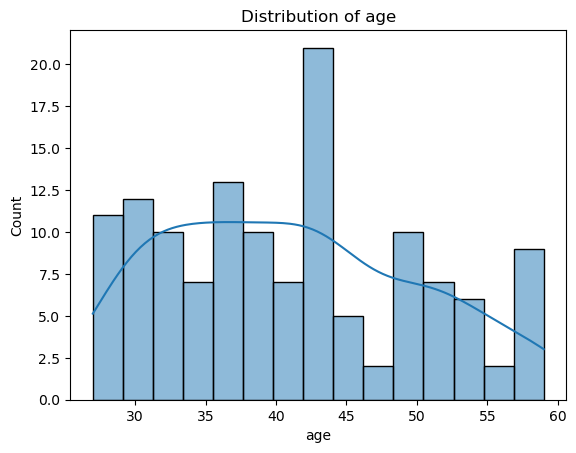


===== sleep_duration =====
count    132.000000
mean       7.082576
std        0.775335
min        5.800000
25%        6.400000
50%        7.150000
75%        7.725000
max        8.500000
Name: sleep_duration, dtype: float64


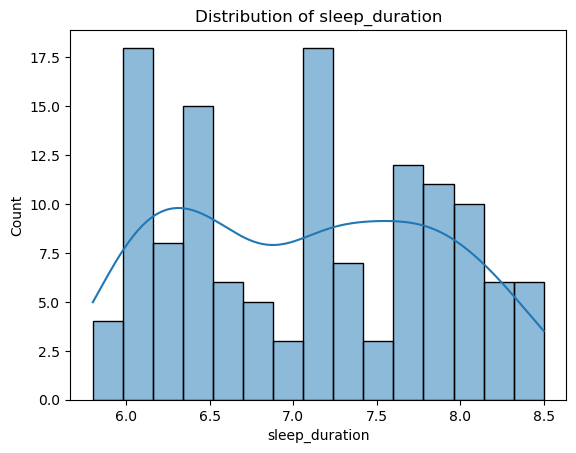


===== quality_of_sleep =====
count    132.000000
mean       7.151515
std        1.269037
min        4.000000
25%        6.000000
50%        7.000000
75%        8.000000
max        9.000000
Name: quality_of_sleep, dtype: float64


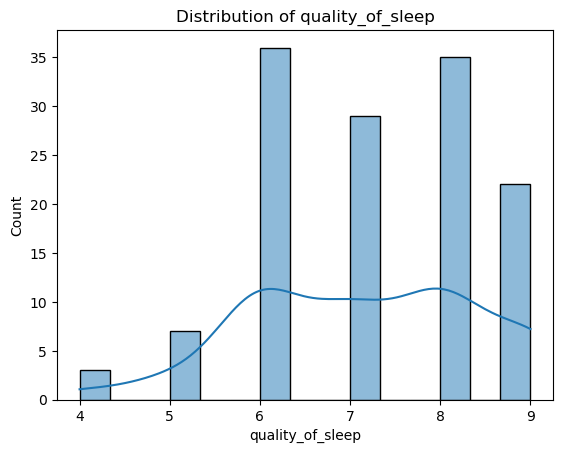


===== physical_activity_level =====
count    132.000000
mean      58.393939
std       20.468840
min       30.000000
25%       44.250000
50%       60.000000
75%       75.000000
max       90.000000
Name: physical_activity_level, dtype: float64


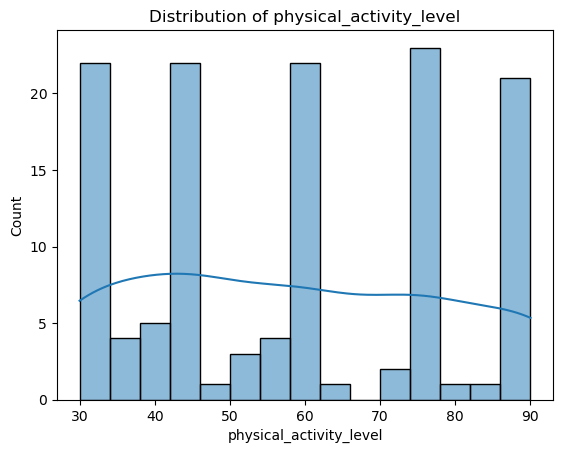


===== stress_level =====
count    132.000000
mean       5.537879
std        1.740428
min        3.000000
25%        4.000000
50%        6.000000
75%        7.000000
max        8.000000
Name: stress_level, dtype: float64


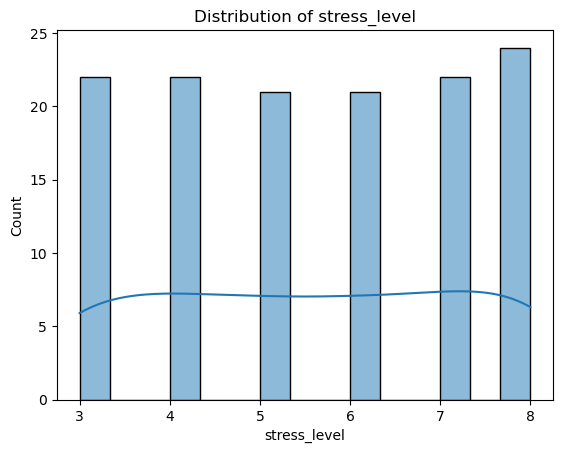


===== heart_rate =====
count    132.000000
mean      71.204545
std        4.867306
min       65.000000
25%       68.000000
50%       70.000000
75%       74.000000
max       86.000000
Name: heart_rate, dtype: float64


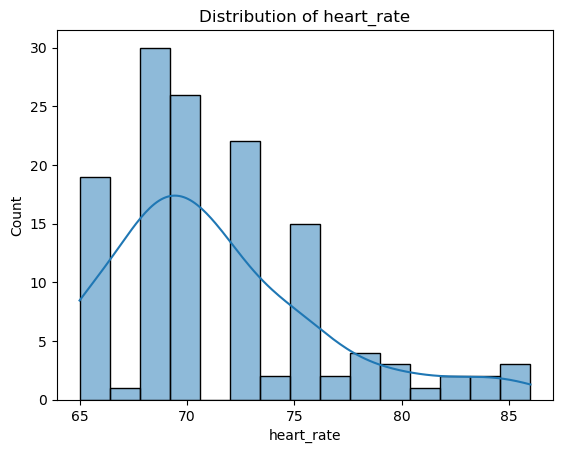


===== daily_steps =====
count      132.000000
mean      6637.878788
std       1766.288657
min       3000.000000
25%       5000.000000
50%       7000.000000
75%       8000.000000
max      10000.000000
Name: daily_steps, dtype: float64


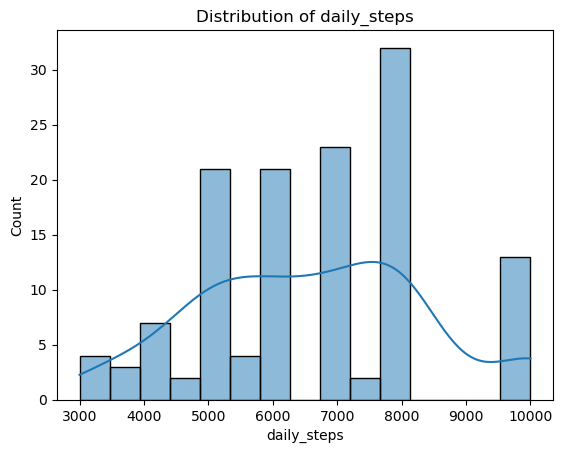


===== systolic =====
count    132.000000
mean     128.363636
std        7.825650
min      115.000000
25%      120.750000
50%      130.000000
75%      135.000000
max      142.000000
Name: systolic, dtype: float64


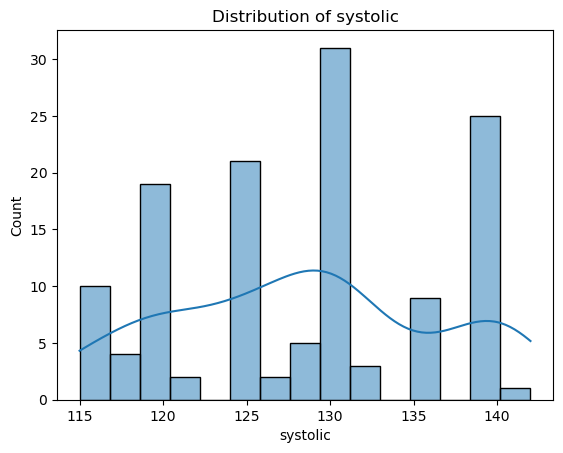


===== diastolic =====
count    132.000000
mean      84.537879
std        6.049926
min       75.000000
25%       80.000000
50%       85.000000
75%       88.500000
max       95.000000
Name: diastolic, dtype: float64


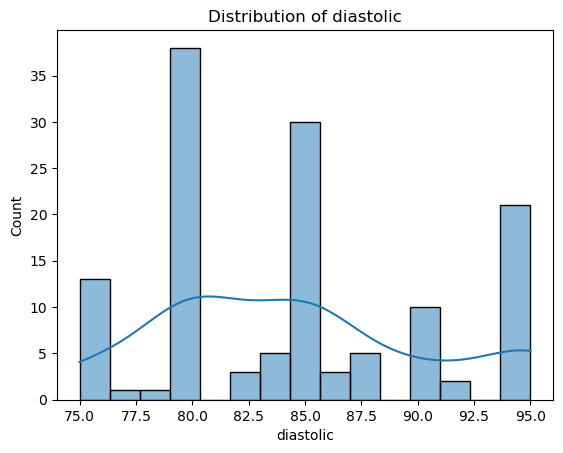


===== gender =====
gender
Male      67
Female    65
Name: count, dtype: int64


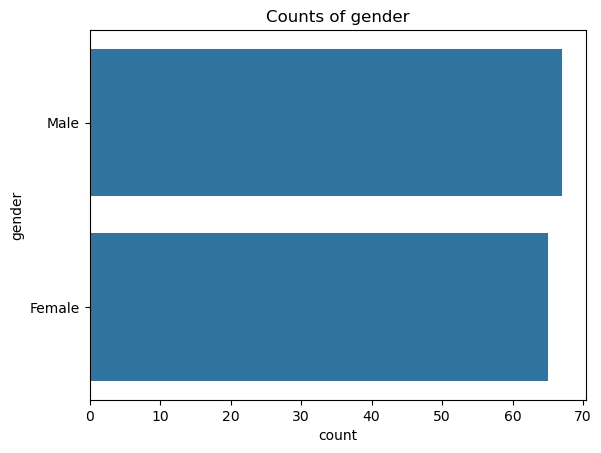


===== occupation =====
occupation
Nurse                   29
Doctor                  24
Engineer                22
Teacher                 15
Lawyer                  15
Accountant              11
Salesperson              9
Software Engineer        3
Scientist                2
Sales Representative     1
Manager                  1
Name: count, dtype: int64


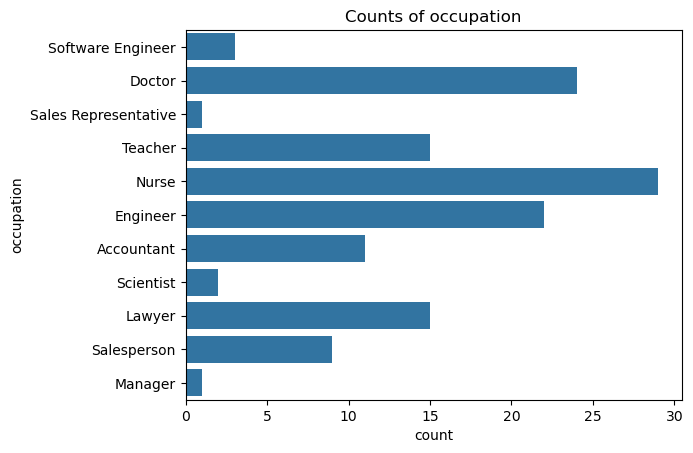


===== bmi_category =====
bmi_category
Normal        73
Overweight    52
Obese          7
Name: count, dtype: int64


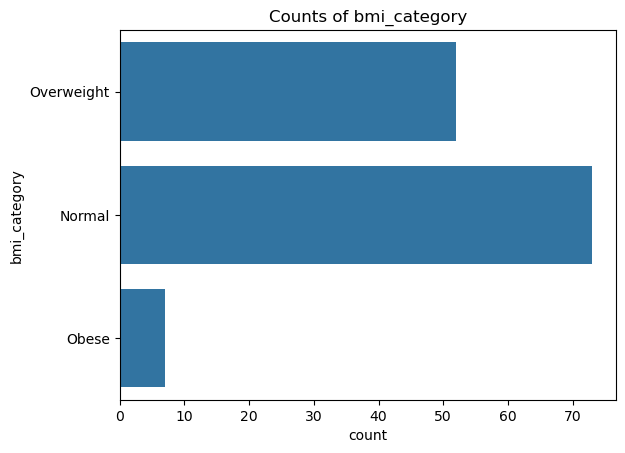


===== sleep_disorder =====
sleep_disorder
No Disorder    73
Sleep Apnea    30
Insomnia       29
Name: count, dtype: int64


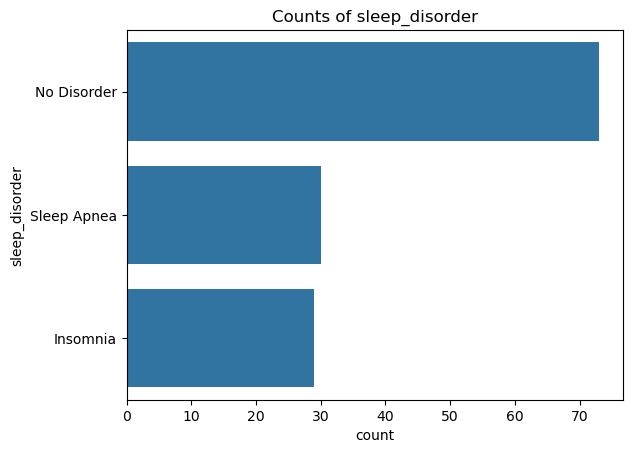

In [20]:
univariate_analysis(sleep_df_clean, numeric_cols, categorical_cols)

### 5. Bivariate Analysis 
Analysis of the relationship between two variables.

- Explore correlations or associations between variables.
- Identify whether there is a significant relationship before building predictive models.

In [21]:
def correlation_analysis(df, numeric_columns, target_col, categorical_columns):
    
    # Correlation heatmap
    corr = sleep_df_clean.select_dtypes(include=['int64', 'float64']).corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title("Correlation Matrix")
    plt.show()


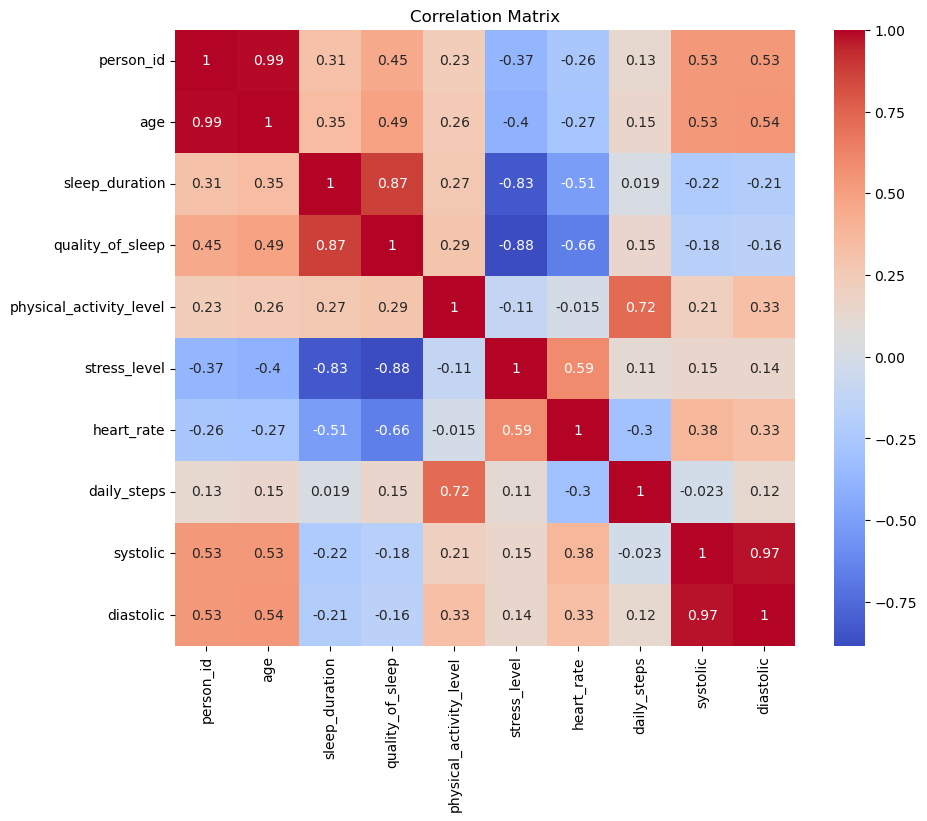

In [22]:
target_col = 'sleep_disorder'
correlation_analysis(sleep_df_clean, numeric_cols, target_col, categorical_cols)

### 7. Hypothesis Testing

#### 7.1 Setup and Configuration

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import os

### Primary Hypothesis (H1)
Individuals with high stress, high BMI, low sleep duration, and poor sleep quality are significantly more likely to have a sleep disorder.

In [41]:
sleep_df_clean['has_disorder'] = sleep_df_clean['sleep_disorder'].apply(lambda x: 0 if x == "No Disorder" else 1)

features = [
    'stress_level',
    'sleep_duration',
    'quality_of_sleep',
    'physical_activity_level',
    'heart_rate',
    'daily_steps',
    'systolic'
]


X = sleep_df_clean[features]
y = sleep_df_clean['has_disorder']


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)


from sklearn.metrics import classification_report, roc_auc_score

y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))


coeffs = pd.DataFrame({
    'Feature': features,
    'Coefficient': log_reg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

coeffs

              precision    recall  f1-score   support

           0       0.81      0.72      0.76        18
           1       0.71      0.80      0.75        15

    accuracy                           0.76        33
   macro avg       0.76      0.76      0.76        33
weighted avg       0.76      0.76      0.76        33

ROC-AUC: 0.787037037037037


,Feature,Coefficient
6,systolic,0.214925
4,heart_rate,0.183709
1,sleep_duration,0.062172
5,daily_steps,0.000423
3,physical_activity_level,-0.053785
0,stress_level,-0.396165
2,quality_of_sleep,-0.597751


#### Overall Conclusions
**1.** The model validates key physiological predictors
Systolic BP and heart rate are significant positive predictors of sleep disorder risk.

This supports hypothesis H1e.

**2.** Sleep quality is the most meaningful negative predictor

Higher sleep quality strongly reduces the likelihood of a disorder, supporting part of H1 (poor sleep quality → higher risk).

**3.** Stress behaves in the opposite direction than expected

The negative coefficient contradicts hypotheses H1 and H1b.
In this dataset, stress does not function as a valid predictor.

**4.** Physical activity shows a protective effect

The effect is modest but aligns with hypothesis H1d.

### H1a: Obesity increases likelihood of sleep apnea

In [24]:
# Sleep disorder flags
sleep_df_clean['is_insomnia'] = sleep_df_clean['sleep_disorder'].apply(lambda x: 1 if x == "Insomnia" else 0)
sleep_df_clean['is_apnea'] = sleep_df_clean['sleep_disorder'].apply(lambda x: 1 if x == "Sleep Apnea" else 0)

In [25]:
# BMI flag for obesity
sleep_df_clean['is_obese'] = sleep_df_clean['bmi_category'].apply(lambda x: 1 if x == "Obese" else 0)

In [26]:
ct = pd.crosstab(sleep_df_clean['is_obese'], sleep_df_clean['is_apnea'])

chi2, p, dof, exp = chi2_contingency(ct)

print("Chi-square:", chi2)
print("p-value:", p)

Chi-square: 3.1307294117647064
p-value: 0.07682935807158636


Text(0.5, 1.0, 'Distribution of BMI Categories by Sleep Disorder')

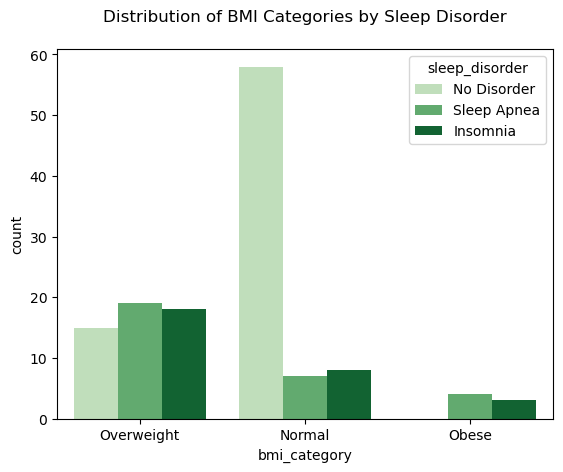

In [27]:
ax = sns.countplot(
    x = sleep_df_clean["bmi_category"],
    hue = sleep_df_clean["sleep_disorder"],
    data = sleep_df_clean,
    palette = [my_palette1[1], my_palette1[3], my_palette1[5]]
)
ax.set_title("Distribution of BMI Categories by Sleep Disorder", pad=20)

#### Overall conclusion
The data suggest a clinically relevant relationship between obesity and sleep apnea, but it cannot be confirmed statistically at the conventional significance level because of the small number of cases.

### H1b: Higher stress correlates with insomnia

In [30]:
def boxplot_analysis(df, numeric_columns, target_col, categorical_columns=None):
    
    for col in numeric_columns:
        plt.figure(figsize=(8, 5))
        sns.boxplot(data=df, x=target_col, y=col)
        plt.title(f'Boxplot of {col} by {target_col}')
        plt.xlabel(target_col)
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()

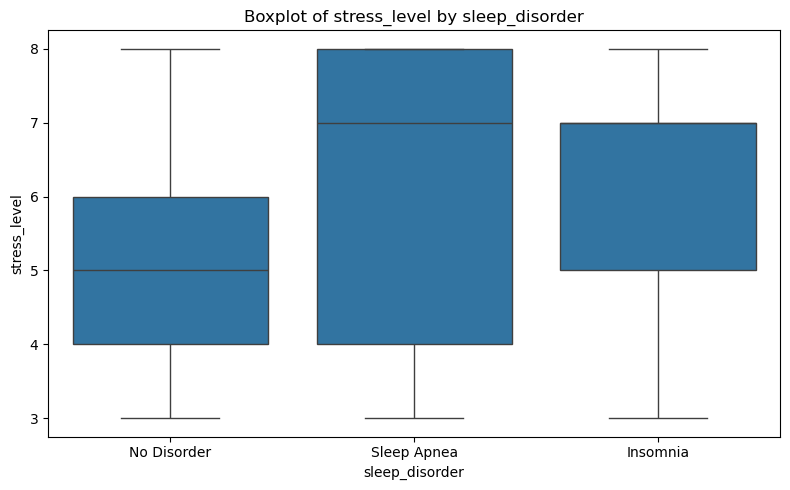

<function __main__.boxplot_analysis(df, numeric_columns, target_col, categorical_columns=None)>

In [31]:
boxplot_analysis(
    sleep_df_clean,
    numeric_columns=['stress_level'],
    target_col='sleep_disorder',
    categorical_columns=['sleep_disorder']
)
boxplot_analysis

### H1c: Sleeping <6 hours increases disorder risk

<Figure size 1000x600 with 0 Axes>

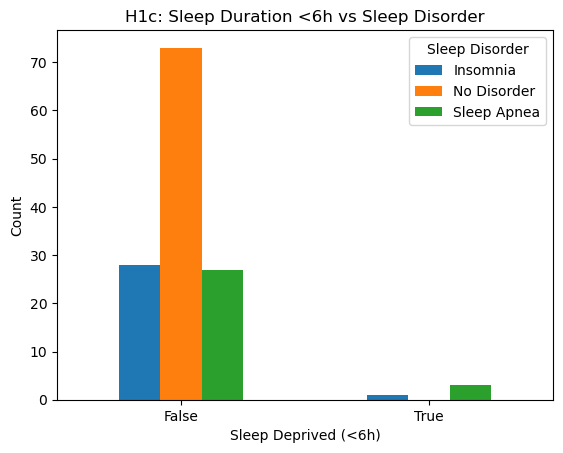

sleep_disorder  Insomnia  No Disorder  Sleep Apnea
sleep_deprived                                    
False             21.875     57.03125     21.09375
True              25.000      0.00000     75.00000


In [32]:
sleep_df_clean['sleep_deprived'] = sleep_df_clean['sleep_duration'] < 6

plt.figure(figsize=(10, 6))
pd.crosstab(sleep_df_clean['sleep_deprived'], sleep_df_clean['sleep_disorder']).plot(kind='bar')
plt.title('H1c: Sleep Duration <6h vs Sleep Disorder')
plt.xlabel('Sleep Deprived (<6h)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Sleep Disorder')
plt.show()

print(pd.crosstab(sleep_df_clean['sleep_deprived'], sleep_df_clean['sleep_disorder'], normalize='index') * 100)

### H1d: Low physical activity (<40 min/day) increases disorder prevalence

<Figure size 1000x600 with 0 Axes>

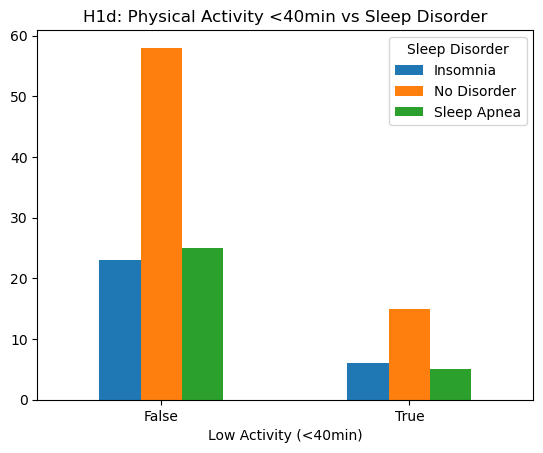

In [33]:
sleep_df_clean['low_activity'] = sleep_df_clean['physical_activity_level'] < 40


plt.figure(figsize=(10, 6))
pd.crosstab(sleep_df_clean['low_activity'], sleep_df_clean['sleep_disorder']).plot(kind='bar')
plt.title('H1d: Physical Activity <40min vs Sleep Disorder')
plt.xlabel('Low Activity (<40min)')
plt.xticks(rotation=0)
plt.legend(title='Sleep Disorder')
plt.show()

### H1e: High heart rate / BP increases apnea risk.

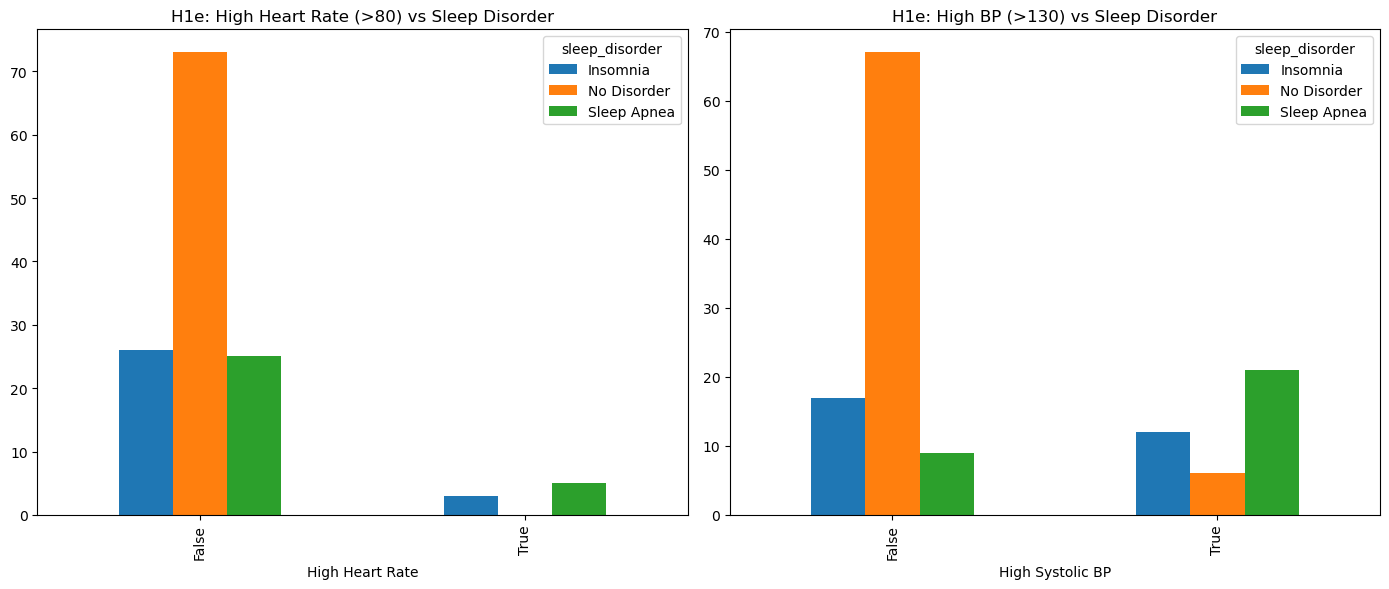

In [43]:
# High heart rate: >80 bpm
sleep_df_clean['high_hr'] = sleep_df_clean['heart_rate'] > 80

# High BP: Systolic >130
sleep_df_clean['high_bp'] = sleep_df_clean['systolic'] > 130

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Heart Rate
pd.crosstab(sleep_df_clean['high_hr'], sleep_df_clean['sleep_disorder']).plot(kind='bar', ax=axes[0])
axes[0].set_title('H1e: High Heart Rate (>80) vs Sleep Disorder')
axes[0].set_xlabel('High Heart Rate')

# Blood Pressure
pd.crosstab(sleep_df_clean['high_bp'], sleep_df_clean['sleep_disorder']).plot(kind='bar', ax=axes[1])
axes[1].set_title('H1e: High BP (>130) vs Sleep Disorder')
axes[1].set_xlabel('High Systolic BP')

plt.tight_layout()
plt.show()